# COGS 108 - EDA Checkpoint

# Names

- Jamie Wei
- Alexis Garduno
- James Daza
- Aleksander Archipov

<a id='research_question'></a>
# Research Question

- Does the number of times a player is traded predict that player's performance (e.g. average total points scored/game, average minutes played/game, etc) in an NBA game? Also, does the turn-over rate (e.g. number of players traded within a team/season) of a NBA team affect the likelihood that the team will reach the NBA finals (evidenced by the last 20 years of NBA games)?

# Dataset(s)

#### Source Name: NBA_API
- Link to the dataset: https://github.com/swar/nba_api
- Number of observations: N/A
- API Client that allows access to various NBA's stats API endpoints

#### Source Name: NBA Stats
- Link to the dataset: https://www.nba.com/stats/
- Player stats from 10 random teams ranging from 2016-2021

We began with two sources, primarily relying on the NBA_API to construct datastreams. We performed some simple quality checks to ensure that the dataset we pulled from the NBA_API was consistent with the data shown on the NBA stats site.

#### Dataset: PlayerStats-Team Ranking 
- ***Description:*** This dataset contains a player's performance for an individual season; each row is uniquely defined for a player's performance for that team in an individual season. If players were traded in the middle of the season, there would be two rows per player. This dataset also contains information about how often players were traded in a given season. This dataset was merged to team performance statistics, largely team rankings over an individual season. This dataset has a header of "working dataset."
- ***Observations:*** 2,892 players per season


# Setup

In [2]:
#data wrangling, etc
import pandas as pd
import numpy as np
import time

#import datasets
from nba_api.stats.static import players
from nba_api.stats.endpoints import playercareerstats

#graphic packages
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from scipy.stats import rankdata

import seaborn as sns

# Dataset

### Gathering Teams

This dataset shows the team roster and will be used as the key to merge the team standings over a season with player-level performance statistics. This dataset serves as a key or linker file between datasets.

In [14]:
#Import the roster of teams from the NBA API
from nba_api.stats.static import teams
nba_teams = teams.get_teams()
#Obtain a full list of all abbreviations - will need abbreviations to identify team statistics
nba_teams_df=pd.DataFrame(nba_teams)
nba_teams_df.head(10)

,id,full_name,abbreviation,nickname,city,state,year_founded
0,1610612737,Atlanta Hawks,ATL,Hawks,Atlanta,Atlanta,1949
1,1610612738,Boston Celtics,BOS,Celtics,Boston,Massachusetts,1946
2,1610612739,Cleveland Cavaliers,CLE,Cavaliers,Cleveland,Ohio,1970
3,1610612740,New Orleans Pelicans,NOP,Pelicans,New Orleans,Louisiana,2002
4,1610612741,Chicago Bulls,CHI,Bulls,Chicago,Illinois,1966
5,1610612742,Dallas Mavericks,DAL,Mavericks,Dallas,Texas,1980
6,1610612743,Denver Nuggets,DEN,Nuggets,Denver,Colorado,1976
7,1610612744,Golden State Warriors,GSW,Warriors,Golden State,California,1946
8,1610612745,Houston Rockets,HOU,Rockets,Houston,Texas,1967
9,1610612746,Los Angeles Clippers,LAC,Clippers,Los Angeles,California,1970


### PlayersStats Import (Data)

PlayerStats dataset is shown below, where each row correponds to a player's performance on a given team in an individual season. Since we are looking at the number of players who were traded in a given season, we calculated the number of times that player was traded in a given season. There will be two rows for an individual for an individual season if they were traded teams mid-season.

In [126]:
dataDf = pd.read_csv("PlayerStats.csv")
print(dataDf.shape) #total number of observations
dataDf=dataDf.merge(nba_teams_df, left_on='TEAM_ID', right_on='id')

#change variables in terms of average performance over the game
game_stats= ['MIN', 'PTS', 'FGM', 'FG_PCT', 'FG3_PCT', 'FT_PCT', 'OREB', 'DREB', 'AST', 'STL', 'BLK']
for i in game_stats:
    dataDf=dataDf.assign(i=dataDf.get(i)/dataDf.get('GP'))

dataDf = dataDf.drop(columns=['Unnamed: 0','id'])
print(dataDf.shape) #QA check (group ids dropped that were not in original roster)
print(list(set(dataDf.get('nickname')))) #names in dataset
dataDf.head(10)

(3218, 33)
(2892, 39)
['Cavaliers', 'Wizards', 'Jazz', 'Bucks', 'Trail Blazers', 'Pelicans', 'Bulls', 'Spurs', 'Pistons', '76ers', 'Heat', 'Lakers', 'Kings', 'Magic', 'Hawks', 'Mavericks', 'Timberwolves', 'Suns', 'Nets', 'Pacers', 'Knicks', 'Raptors', 'Clippers', 'Nuggets', 'Rockets', 'Thunder', 'Grizzlies', 'Celtics', 'Warriors', 'Hornets']


,PLAYER_ID,SEASON_ID,LEAGUE_ID,TEAM_ID,TEAM_ABBREVIATION,PLAYER_AGE,GP,GS,MIN,FGM,...,Traded 2018-19,Traded 2019-20,Traded 2020-21,full_name,abbreviation,nickname,city,state,year_founded,i
0,1630208,2020-21,0,1610612766,CHA,23.0,18,0,63.0,4,...,0,0,0,Charlotte Hornets,CHA,Hornets,Charlotte,North Carolina,1988,0.000000
1,202714,2018-19,0,1610612766,CHA,29.0,4,0,42.0,2,...,1,0,0,Charlotte Hornets,CHA,Hornets,Charlotte,North Carolina,1988,0.000000
2,1626163,2016-17,0,1610612766,CHA,24.0,75,16,1954.0,320,...,0,0,0,Charlotte Hornets,CHA,Hornets,Charlotte,North Carolina,1988,0.453333
3,1626163,2017-18,0,1610612766,CHA,25.0,79,4,1835.0,307,...,0,0,0,Charlotte Hornets,CHA,Hornets,Charlotte,North Carolina,1988,0.240506
4,1626163,2018-19,0,1610612766,CHA,26.0,47,0,755.0,138,...,0,0,0,Charlotte Hornets,CHA,Hornets,Charlotte,North Carolina,1988,0.255319
5,1630268,2020-21,0,1610612766,CHA,22.0,7,0,26.0,2,...,0,0,0,Charlotte Hornets,CHA,Hornets,Charlotte,North Carolina,1988,0.142857
6,1626179,2019-20,0,1610612766,CHA,26.0,63,63,2165.0,398,...,0,0,0,Charlotte Hornets,CHA,Hornets,Charlotte,North Carolina,1988,0.158730
7,1626179,2020-21,0,1610612766,CHA,27.0,69,69,2383.0,510,...,0,0,0,Charlotte Hornets,CHA,Hornets,Charlotte,North Carolina,1988,0.376812
8,1626174,2016-17,0,1610612766,CHA,21.0,13,0,107.0,12,...,1,0,0,Charlotte Hornets,CHA,Hornets,Charlotte,North Carolina,1988,0.461538
9,1626195,2017-18,0,1610612766,CHA,24.0,22,1,262.0,42,...,0,0,0,Charlotte Hornets,CHA,Hornets,Charlotte,North Carolina,1988,0.409091


### Import Ranking Data Reflecting Overall Team Performance (Data)

In [127]:
#import the NBA team ranks to reflect overall performance
NBA_team_rank=pd.read_csv("NBAstanding.csv")

#retired code from prior data checkpoint

#dictionary to facilitate merging the player-level information with team ranking information
# team_dict = {'76ers':'Philadelphia 76ers','Kings': 'Sacramento Kings',
#              'Minnesota Timberwolves':'	Timberwolves','Suns':'Phoenix Suns',
#              'Bucks': 'Milwaukee Bucks','Celtics':'Boston Celtics',
#              'Bulls':'Chicago Bulls','Warriors':'Golden State Warriors','Magic':'Orlando Magic',
#              'Spurs':'San Antonio Spurs'}
#replace values for roster with key
#NBA_team_rank.replace({"Team_Name": team_dict},inplace=True)
#restrict to teams listed in the roster
#NBA_team_rank=NBA_team_rank[NBA_team_rank['Team_Name'].isin(list(set(dataDf.get('TEAM_NAME'))))]
NBA_team_rank.head(10)

,Team_Name,Wins_2022,PCT_2022,Wins_2021,PCT_2021,Wins_2020,PCT_2020,Wins_2019,PCT_2019,Wins_2018,...,Wins_2017,PCT_2017,Wins_2016,PCT_2016,Wins_2015,PCT_2015,Wins_2014,PCT_2014,Wins_2013,PCT_2013
0,Heat,38.0,64.0,40.0,56.0,44.0,60.0,39.0,47.0,44.0,...,41.0,50.0,48.0,59.0,37.0,45.0,54.0,66.0,66.0,80.0
1,Bulls,38.0,64.0,31.0,43.0,22.0,34.0,22.0,27.0,44.0,...,41.0,50.0,42.0,51.0,50.0,61.0,48.0,59.0,45.0,55.0
2,76ers,35.0,60.0,49.0,68.0,43.0,59.0,51.0,62.0,52.0,...,28.0,34.0,10.0,12.0,18.0,22.0,19.0,23.0,34.0,42.0
3,Cavaliers,35.0,60.0,22.0,30.0,19.0,29.0,19.0,23.0,50.0,...,51.0,62.0,57.0,70.0,53.0,65.0,33.0,40.0,24.0,29.0
4,Bucks,36.0,60.0,46.0,64.0,56.0,76.0,60.0,73.0,44.0,...,42.0,51.0,33.0,40.0,41.0,50.0,15.0,18.0,38.0,46.0
5,Celtics,34.0,57.0,36.0,50.0,48.0,66.0,49.0,60.0,55.0,...,53.0,65.0,48.0,59.0,40.0,49.0,25.0,30.0,41.0,51.0
6,Raptors,32.0,56.0,27.0,37.0,53.0,74.0,58.0,70.0,59.0,...,51.0,62.0,56.0,68.0,49.0,60.0,48.0,59.0,34.0,42.0
7,Nets,31.0,53.0,48.0,66.0,35.0,49.0,42.0,51.0,28.0,...,20.0,24.0,21.0,26.0,38.0,46.0,44.0,54.0,49.0,60.0
8,Hawks,28.0,48.0,41.0,57.0,20.0,30.0,29.0,35.0,24.0,...,43.0,52.0,48.0,59.0,60.0,73.0,38.0,46.0,44.0,54.0
9,Hornets,29.0,48.0,33.0,45.0,23.0,35.0,39.0,48.0,36.0,...,36.0,44.0,48.0,59.0,33.0,40.0,43.0,52.0,27.0,33.0


### PlayerStats-TeamRanking Merge: Working Dataset (Data)
Description: At this stage, we are merging player statistics with the team ranking information.

In [128]:
#merge the datasets
dataDfm=dataDf.merge(NBA_team_rank, left_on='nickname', right_on='Team_Name')
print(dataDf.shape)
print(dataDfm.shape)
print(dataDfm.columns)
dataDfm

(2892, 39)
(2892, 60)
Index(['PLAYER_ID', 'SEASON_ID', 'LEAGUE_ID', 'TEAM_ID', 'TEAM_ABBREVIATION',
       'PLAYER_AGE', 'GP', 'GS', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A',
       'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL',
       'BLK', 'TOV', 'PF', 'PTS', 'Traded 2016-17', 'Traded 2017-18',
       'Traded 2018-19', 'Traded 2019-20', 'Traded 2020-21', 'full_name',
       'abbreviation', 'nickname', 'city', 'state', 'year_founded', 'i',
       'Team_Name', ' Wins_2022', 'PCT_2022', 'Wins_2021', 'PCT_2021',
       'Wins_2020', 'PCT_2020', 'Wins_2019', 'PCT_2019', 'Wins_2018',
       'PCT_2018', 'Wins_2017', 'PCT_2017', 'Wins_2016', 'PCT_2016',
       'Wins_2015', 'PCT_2015', 'Wins_2014', 'PCT_2014', 'Wins_2013',
       'PCT_2013'],
      dtype='object')


,PLAYER_ID,SEASON_ID,LEAGUE_ID,TEAM_ID,TEAM_ABBREVIATION,PLAYER_AGE,GP,GS,MIN,FGM,...,Wins_2017,PCT_2017,Wins_2016,PCT_2016,Wins_2015,PCT_2015,Wins_2014,PCT_2014,Wins_2013,PCT_2013
0,1630208,2020-21,0,1610612766,CHA,23.0,18,0,63.0,4,...,36.0,44.0,48.0,59.0,33.0,40.0,43.0,52.0,27.0,33.0
1,202714,2018-19,0,1610612766,CHA,29.0,4,0,42.0,2,...,36.0,44.0,48.0,59.0,33.0,40.0,43.0,52.0,27.0,33.0
2,1626163,2016-17,0,1610612766,CHA,24.0,75,16,1954.0,320,...,36.0,44.0,48.0,59.0,33.0,40.0,43.0,52.0,27.0,33.0
3,1626163,2017-18,0,1610612766,CHA,25.0,79,4,1835.0,307,...,36.0,44.0,48.0,59.0,33.0,40.0,43.0,52.0,27.0,33.0
4,1626163,2018-19,0,1610612766,CHA,26.0,47,0,755.0,138,...,36.0,44.0,48.0,59.0,33.0,40.0,43.0,52.0,27.0,33.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2887,1627817,2016-17,0,1610612757,POR,22.0,16,0,80.0,13,...,41.0,50.0,44.0,54.0,51.0,62.0,54.0,66.0,33.0,40.0
2888,1627834,2017-18,0,1610612757,POR,20.0,1,0,4.0,1,...,41.0,50.0,44.0,54.0,51.0,62.0,54.0,66.0,33.0,40.0
2889,1627884,2020-21,0,1610612757,POR,24.0,58,43,1318.0,147,...,41.0,50.0,44.0,54.0,51.0,62.0,54.0,66.0,33.0,40.0
2890,202683,2018-19,0,1610612757,POR,27.0,23,8,512.0,124,...,41.0,50.0,44.0,54.0,51.0,62.0,54.0,66.0,33.0,40.0


#### Quality Check: Check for Duplicates

In [129]:
#Times traded has duplicated measures of times traded for the team
#Deduplication only has unique information for each team and for each season. 
dataDfm_dedup=dataDfm.drop_duplicates(subset=['TEAM_ID','SEASON_ID','PLAYER_ID'])
dataDfm_dedup.shape

(2892, 60)

## Data Analysis & Results (EDA)

### Summary Statistics 

***Season Trading Summary***: We are investigating the extent to which a player was traded over an annual basis. There were no evidence of trades in the 2016-2017 season; yet, it appears that every other year, there is an increase in the proportion of players traded in an individual season. On average in a given season, 11% of players were traded in a given season, with a peak in trades every other year. Over the last five years, the 2018-2019 season had the largest proportion of players traded in a given season.

***Team Trading Summary***: On average, 11.4% of players were traded in a season, and on average over the last five seasons, 11.3% of players were traded on average in an individual team. In the 2018-2019 season, the top five teams who traded the largest proportion of players on their team roster was the Knicks (29.7%), followed by Pistons (29.6%), 76ers (29.2%), Suns (27.8%), and the Wizards (27.55%). The teams with the lowest proportion of players traded in the 2018-2019 season were the Hornets (3.7%), Pacers (5.9%), Spurs (6.1%), Nuggets (6.4%), and the Warriors (7.8%).

In [130]:
#Examine the number of times traded per season
trade = ['Traded 2016-17', 'Traded 2017-18',
       'Traded 2018-19', 'Traded 2019-20', 'Traded 2020-21']
trade_sum=dataDfm_dedup.get(trade).mean()
trade_sum2=(sum(trade_sum)/len(trade_sum))
print(trade_sum)
print(trade_sum2)

#Estimate the number of trades per team in a season
team_trade_sum=dataDfm_dedup.groupby(['nickname']).mean().get(trade).reset_index().sort_values('Traded 2018-19',ascending=False)
team_trade_sum=team_trade_sum.assign(TradedMean=team_trade_sum.mean(axis=1)) #average over trades (season)
print(team_trade_sum.get('TradedMean').mean())
team_trade_sum.head(5)
# average_team_trades=dataDfm_dedup.groupby(['TEAM_NAME','SEASON_YEAR']).mean().get('TIMES_TRADED').reset_index()
# average_team_trades.sort_values("TIMES_TRADED",ascending=False)

Traded 2016-17    0.000000
Traded 2017-18    0.112379
Traded 2018-19    0.179115
Traded 2019-20    0.119640
Traded 2020-21    0.160788
dtype: float64
0.11438450899031813
0.11271396413188105


,nickname,Traded 2016-17,Traded 2017-18,Traded 2018-19,Traded 2019-20,Traded 2020-21,TradedMean
12,Knicks,0.0,0.127660,0.297872,0.063830,0.159574,0.129787
20,Pistons,0.0,0.163265,0.295918,0.214286,0.193878,0.173469
0,76ers,0.0,0.207547,0.292453,0.122642,0.103774,0.145283
24,Suns,0.0,0.123711,0.278351,0.134021,0.072165,0.121649
29,Wizards,0.0,0.040816,0.275510,0.183673,0.163265,0.132653


In [131]:
team_trade_sum.tail(5)

,nickname,Traded 2016-17,Traded 2017-18,Traded 2018-19,Traded 2019-20,Traded 2020-21,TradedMean
28,Warriors,0.0,0.022222,0.077778,0.155556,0.166667,0.084444
17,Nuggets,0.0,0.063830,0.063830,0.180851,0.180851,0.097872
23,Spurs,0.0,0.048780,0.060976,0.048780,0.085366,0.048780
18,Pacers,0.0,0.059524,0.059524,0.035714,0.142857,0.059524
9,Hornets,0.0,0.073171,0.036585,0.121951,0.012195,0.048780


###  Data Distribution of Player Performance Metrics (Overall)

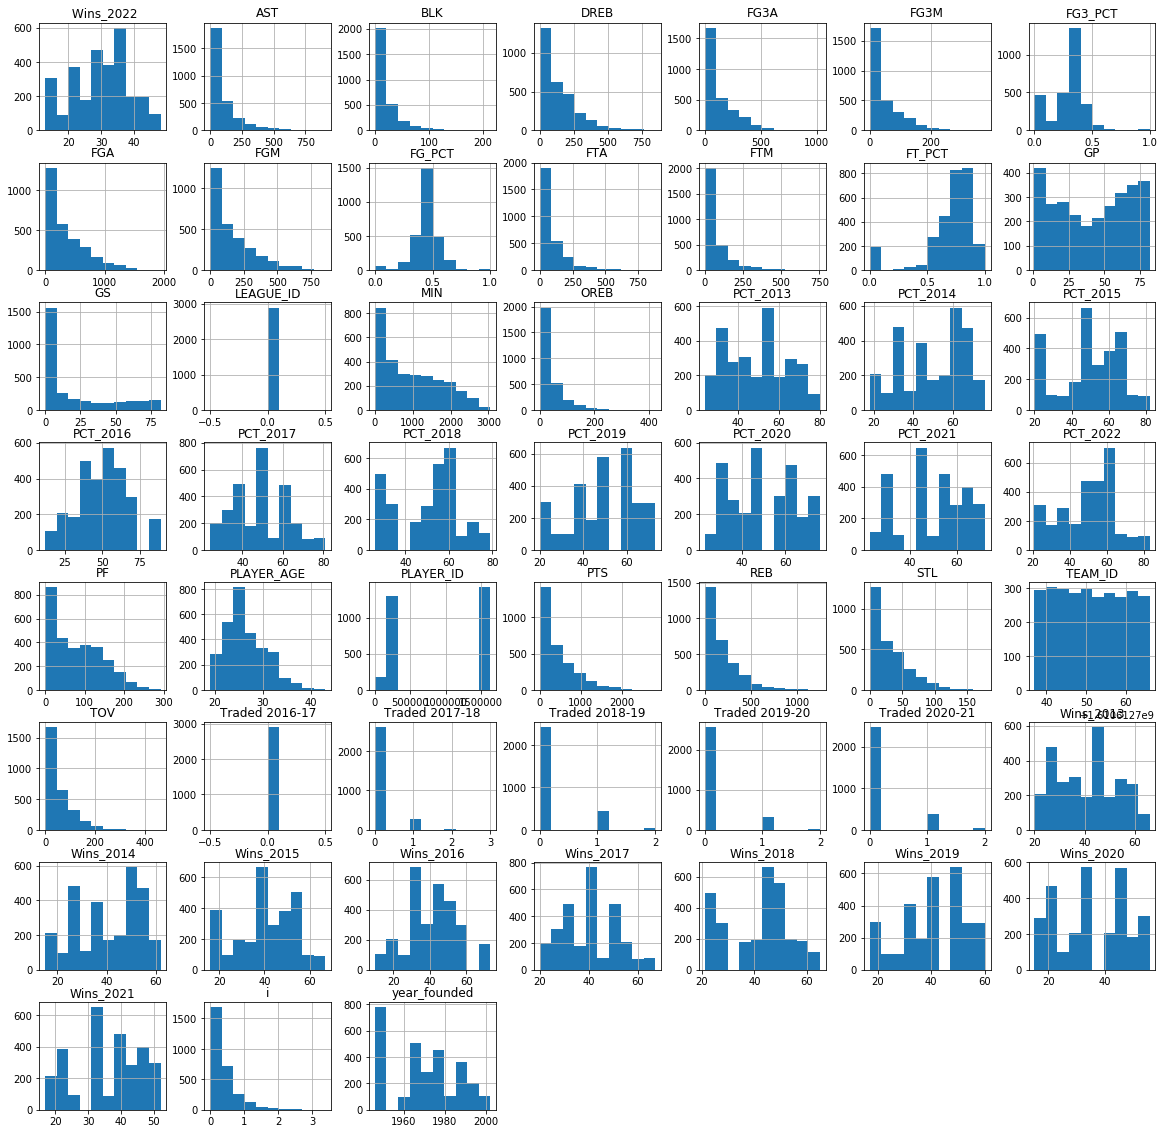

In [132]:
dataDfm.hist(figsize=(20,20))
plt.show()

### Player Distribution of Player Trades Per Team over 5 Seasons

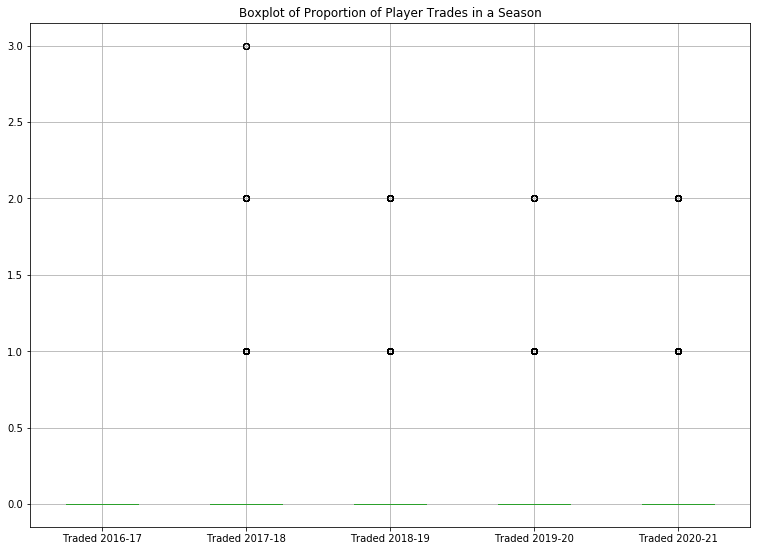

In [133]:
fig = plt.figure(figsize =(10, 7))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
 
# Creating plot
bp = dataDfm.get(trade).boxplot(figsize=(10,10))
plt.title('Boxplot of Proportion of Player Trades in a Season')
# show plot
plt.show()

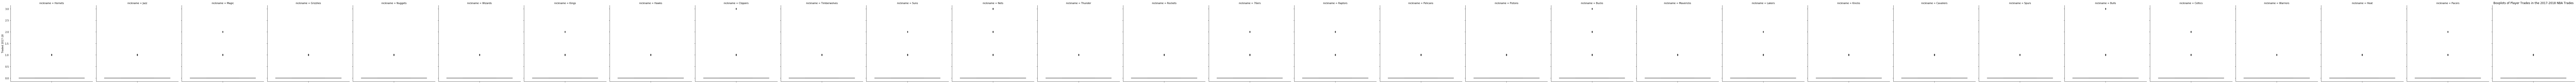

In [83]:
plt2 = sns.catplot(y='Traded 2017-18',
                col="nickname",
                data=dataDfm, kind="box")
plt.title('Boxplots of Player Trades in the 2017-2018 NBA Trades')
plt.show()

#### Dendogram 

This diagram shows hierarchal relationships (ttps://www.displayr.com/what-is-dendrogram/). Note, this is standardized in terms of z-scores. This diagram shows player level characteristics at the indiivdual-level on the left side of the dendogram, and team statistics over the season are shown on the right-side of the dendogram. At this point, the current 2022 season appears to be clustered more closely to 2021, which is the most different from the performance across seasons during the 2018 season.

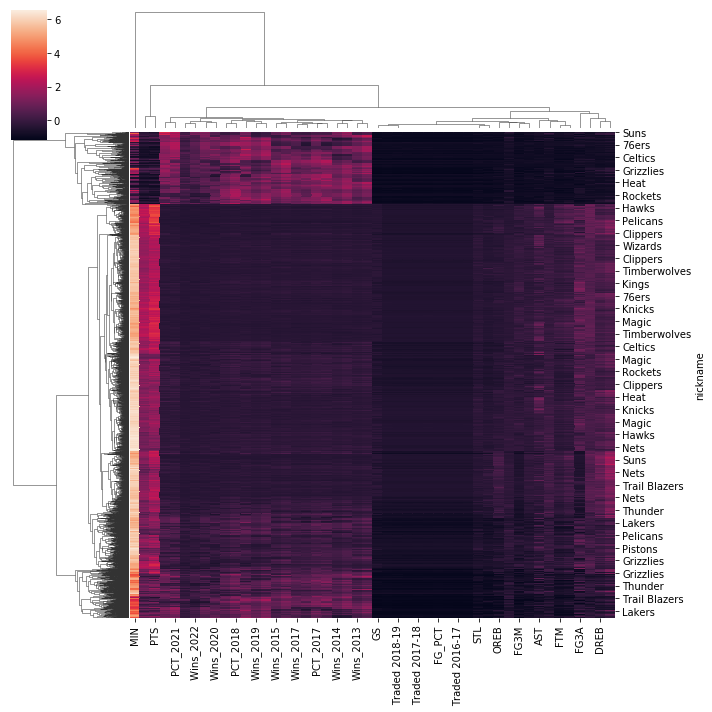

In [139]:
%matplotlib notebook
%matplotlib inline
df = dataDfm
df = df.set_index('nickname')
sns.clustermap(df.drop(columns=['PLAYER_ID', 'SEASON_ID', 'LEAGUE_ID', 'TEAM_ID',
                                'TEAM_ABBREVIATION','abbreviation', 'city', 'state',
                                'Team_Name','year_founded']).select_dtypes(include= np.number),
              z_score=0) #drop team identifiers, standardize to z-score since on different scales
plt.show()

In [141]:
### Sphaghetti Plots

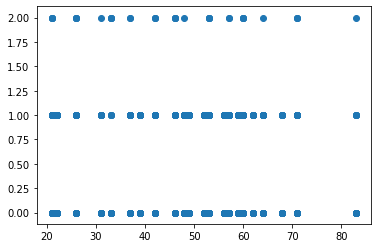

In [140]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter('PCT_2022','Traded 2020-21',data=dataDfm)
plt.show()